In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from functools import partial
# %matplotlib widget


# Goals of this notebook
- provide an intuition of how the SDE model for simple models
- explicitly calculate the solution and investigate the behavior
- vector field of ode
- look at complex model and investigate behavior of the SDE solution
- use SVAG to solve for large models
- showcase SDE behavior for non-convex functions

In [2]:
key = jr.PRNGKey(4)

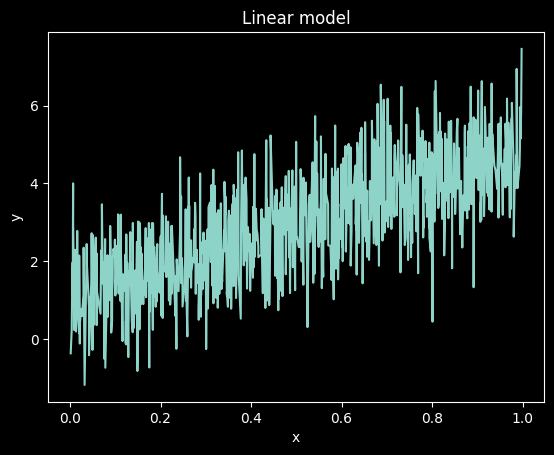

In [3]:
def generate_data(key, n_data):
    x_key, noise_key = jr.split(key)
    weight = 4.0
    bias = 1.0
    x = jr.uniform(x_key, (n_data, ))
    x = jnp.sort(x)
    noise = jr.normal(noise_key, x.shape)
    y = weight * x + bias + noise
    return x, y

n_data = 1000
x, y = generate_data(key, n_data)

plt.title('Linear model')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y);

In [4]:
key, subkey = jr.split(key)
weight, bias = jr.normal(subkey, (2,))
weight_0 = weight.copy()
bias_0 = bias.copy()

In [5]:
@jax.jit
def loss(weight, bias, x, y): return jnp.square(weight * x + bias - y).sum(0)

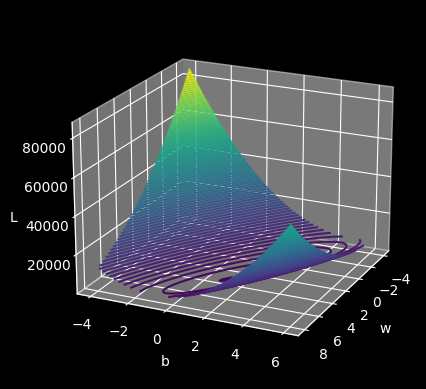

In [6]:
import numpy as np
fig = plt.figure()
ax = plt.axes(projection='3d')
weights_plt = np.linspace(-4, 8, 100)
biases_plt = np.linspace(-4, 6, 100)
W, B = np.meshgrid(weights_plt, biases_plt)
# L = (W * x + B - y) **
# L.shape
L = jnp.sum(((W[None,:,:] * x[:,None,None] + B[None, :, :] - y[:, None, None]) ** 2), 0)
ax.contour3D(W, B, L, 90);
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('L')
ax.view_init(20, 25)
# L

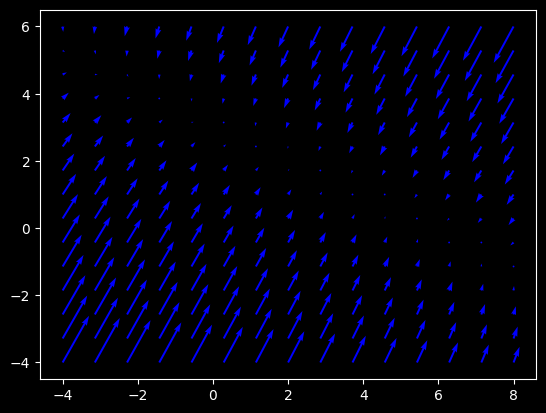

In [7]:
weights_plt = np.linspace(-4, 8, 15)
biases_plt = np.linspace(-4, 6, 15)
W, B = np.meshgrid(weights_plt, biases_plt)


def batched_loss(weight, bias, x, y): return jnp.square(
    weight * x + bias - y).sum(0)


@partial(jax.jit)
def grid_gradients(W, B, x, y):
    return jax.vmap(jax.vmap(jax.grad(
        batched_loss, argnums=(0, 1)), in_axes=(0, 0, None, None)), in_axes=(0, 0, None, None))(W, B, x, y)


dW, dB = grid_gradients(W, B, x, y)
# plt_W = np.asarray(W)
# plt_dW = np.asarray(dW)
# plt_B = np.asarray(B)
# plt_dB = np.asarray(dB)
plt.quiver(W, B, -dW, -dB, color='b')
# plt.show()
# plt_dB.shape


TypeError: Shapes of x (15, 15) and z (100, 100) do not match

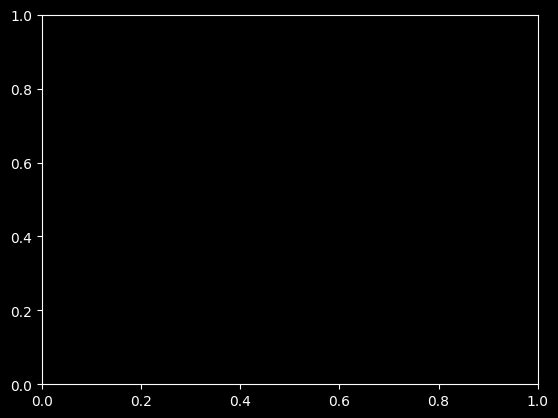

In [8]:
fig, ax = plt.subplots()
CS = ax.contour(W, B, L, 8)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_title('Loss contour')


Weight: 3.136, bias: 1.442
Loss: 1017.139892578125
Weight: 3.754, bias: 1.114
Loss: 985.7225341796875
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188


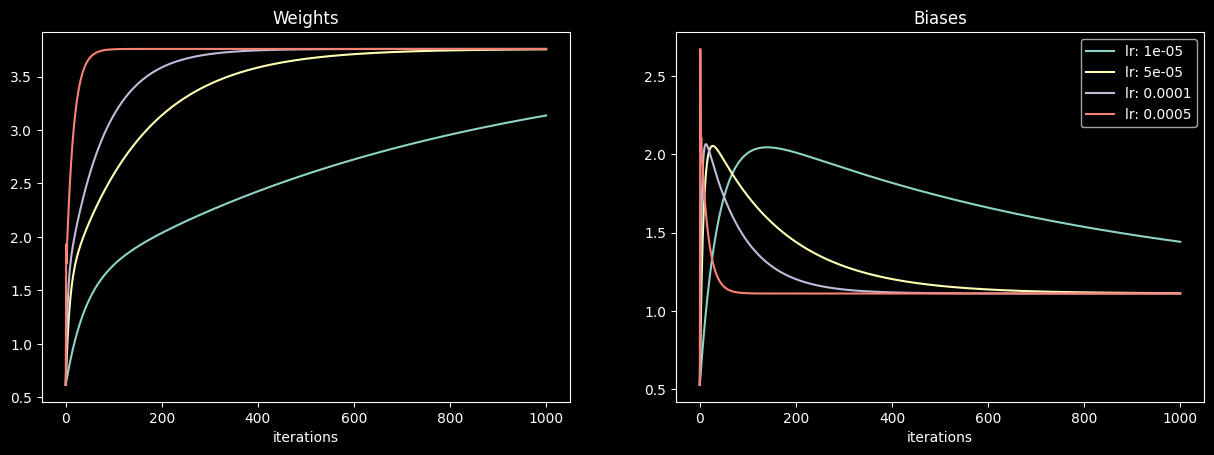

In [ ]:
# Optimization problem
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005]
max_iter = 1000
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(15)
for learning_rate in learning_rates:
    weight = weight_0
    bias = bias_0
    weights = [weight]
    biases = [bias]
    for i in range(max_iter):
        dweight, dbias = jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)
        weight += - learning_rate * dweight
        bias += - learning_rate * dbias
        weights.append(weight)
        biases.append(bias)
    weights = jnp.array(weights)
    biases = jnp.array(biases)
    print(f'Weight: {weight:.3f}, bias: {bias:.3f}')
    print(f'Loss: {loss(weight, bias, x, y)}')
    ax[0].plot(jnp.arange(0, max_iter+1), weights,
               label=f'lr: {learning_rate}')
    ax[0].set_title('Weights')
    ax[1].plot(jnp.arange(0, max_iter+1), biases,
               label=f'lr: {learning_rate}')
    ax[1].set_title('Biases')
    ax[0].set_xlabel('iterations')
    ax[1].set_xlabel('iterations')
    plt.legend()


Weight: 3.136, bias: 1.442
Loss: 1017.139892578125
Weight: 3.754, bias: 1.114
Loss: 985.7225341796875
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188


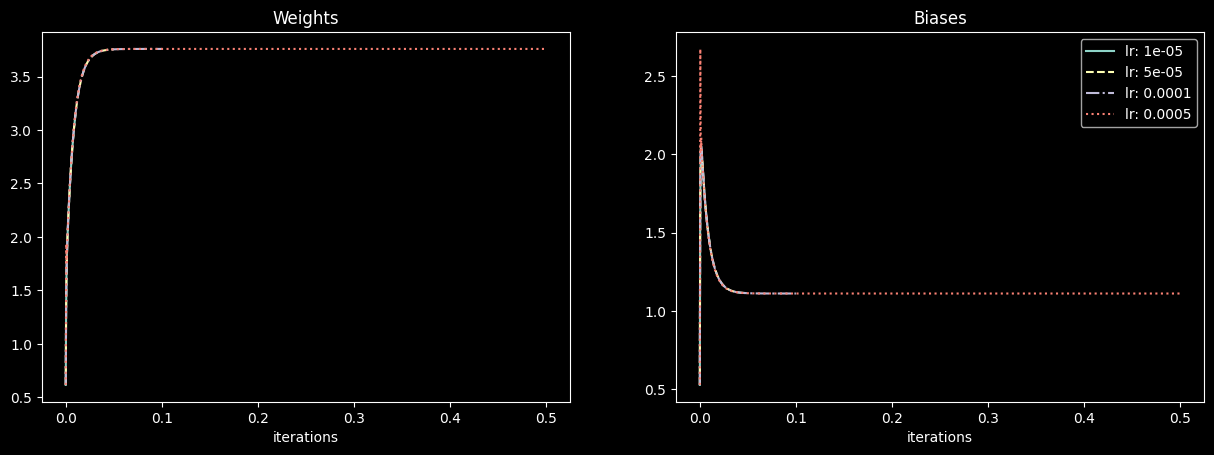

In [ ]:
# Optimization problem
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005]
line_styles = ['-', '--', '-.', ':']
max_iter = 1000
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(15)
for line_style, learning_rate in zip(line_styles, learning_rates):
    weight = weight_0
    bias = bias_0
    weights = [weight]
    biases = [bias]
    for i in range(max_iter):
        dweight, dbias = jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)
        weight += - learning_rate * dweight
        bias += - learning_rate * dbias
        weights.append(weight)
        biases.append(bias)
    weights = jnp.array(weights)
    biases = jnp.array(biases)
    print(f'Weight: {weight:.3f}, bias: {bias:.3f}')
    print(f'Loss: {loss(weight, bias, x, y)}')
    t = jnp.linspace(0, max_iter * learning_rate, max_iter + 1)
    ax[0].plot(t, weights, line_style,
               label=f'lr: {learning_rate}')
    ax[0].set_title('Weights')
    ax[1].plot(t, biases, line_style,
               label=f'lr: {learning_rate}')
    ax[1].set_title('Biases')
    ax[0].set_xlabel('iterations')
    ax[1].set_xlabel('iterations')
    plt.legend()


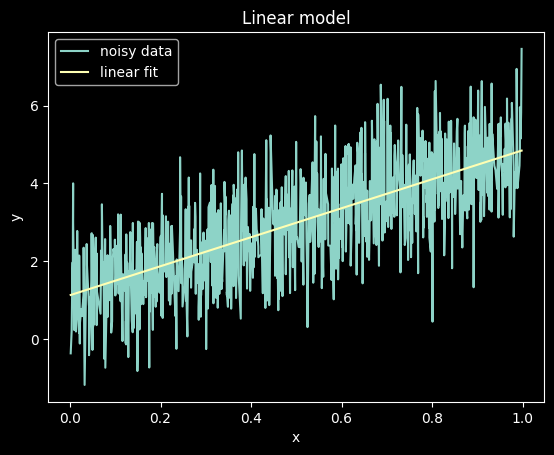

In [ ]:
y_hat = weight * x + bias

plt.title('Linear model')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y, label= 'noisy data')
plt.plot(x, y_hat, label = 'linear fit')
plt.legend();


In [9]:
# Optimization problem
learning_rate = 0.00001
max_iter = 1000
weight = weight_0
bias = bias_0
weights = [weight]
biases = [bias]
for i in range(max_iter):
    dweight, dbias = jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)
    weight += - learning_rate * dweight
    bias += - learning_rate * dbias
    weights.append(weight)
    biases.append(bias)
weights = jnp.array(weights)
biases = jnp.array(biases)
print(f'Weight: {weight:.3f}, bias: {bias:.3f}')
print(f'Loss: {loss(weight, bias, x, y)}')


Weight: 3.136, bias: 1.442
Loss: 1017.139892578125


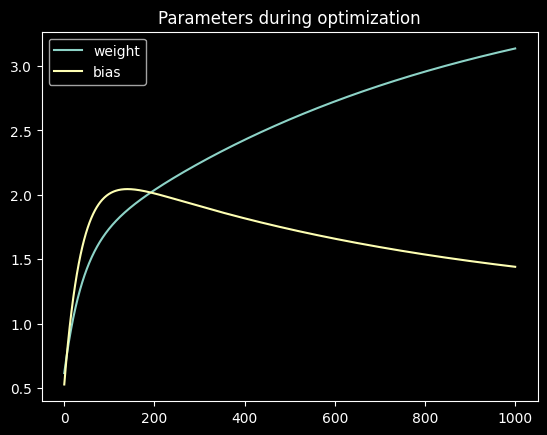

In [10]:
plt.title('Parameters during optimization')
plt.plot(weights, label='weight')
plt.plot(biases, label='bias')
plt.legend();

# Observations

The parameters follow a smooth trajectory.
Update rule: $X_{k+1} = X_k - \eta \nabla f(X_k), \quad X_0 = x$.

This is Euler's method for the system of ODEs: $X'(t) = - \nabla f(X(t)), \quad X(0) = x$.

In the above example we have: $$f(w, b) = \sum_{i=1}^n (w x_i + b - y_i)^2$$.
$$\nabla_w f(w,b) = \sum_{i=1}^n 2 (w x_i + b - y_i) x_i = 2\left(\sum_{i=1}^n x_i^2 \right) w + 2\left(\sum_{i=1}^n x_i \right) b - 2 \sum_{i=1}^n x_i y_i$$
$$\nabla_b f(w,b) = \sum_{i=1}^n 2 (w x_i + b - y_i) = 2\left(\sum_{i=1}^n x_i \right) w + 2 n b - 2 \sum_{i=1}^n y_i$$


In [11]:
x_sum_squared = float((x ** 2).sum())
x_sum = float((x).sum())
x_y_sum = float((x * y).sum())
y_sum = float((y).sum())

w_0 = float(weight_0)
b_0 = float(bias_0)


In [12]:
import sympy as sp
t = sp.symbols('t')
w = sp.Function('w')
b = sp.Function('b')
solution = sp.dsolve([w(t).diff(t) + 2 * x_sum_squared * w(t) + 2 * x_sum * b(t) - 2 *
           x_y_sum, b(t).diff(t) + 2 * x_sum * w(t) + 2 * n_data * b(t) - 2 * y_sum], ics={w(0): w_0, b(0): b_0})
solution

[Eq(w(t), 3.75801825483611 - 0.931281155583232*exp(-2527.149913078*t) - 2.20998679932231*exp(-126.666371101683*t)),
 Eq(b(t), 1.11158383898243 - 1.75558277134754*exp(-2527.149913078*t) + 1.17232812595718*exp(-126.666371101683*t))]

In [13]:
w_t = sp.lambdify([t], solution[0].rhs)
b_t = sp.lambdify([t], solution[1].rhs)
w_t(0), w_0, b_t(0), b_0

(0.6167502999305681, 0.6167502999305725, 0.52832919359207, 0.5283291935920715)

array([0.6167505, 0.8527427, 1.0418615, 1.1945097, 1.3187652, 1.4209023,
       1.5057929, 1.5772219, 1.6381284, 1.6907955, 1.7369972, 1.778112 ,
       1.8152101, 1.8491247, 1.880503 , 1.9098482, 1.9375522, 1.9639192,
       1.9891875, 2.013542 , 2.0371273, 2.0600562, 2.082418 , 2.1042812,
       2.125701 , 2.1467204, 2.1673737, 2.1876879, 2.207685 , 2.2273831,
       2.2467961, 2.2659354, 2.284812 , 2.3034334, 2.3218064, 2.3399377,
       2.3578327, 2.375496 , 2.3929315, 2.4101436, 2.4271362, 2.443912 ,
       2.460475 , 2.4768276, 2.4929738, 2.5089154, 2.524655 , 2.5401964,
       2.5555415, 2.570693 , 2.5856528, 2.6004248, 2.6150098, 2.6294112,
       2.6436315, 2.657672 , 2.6715355, 2.685225 , 2.6987414, 2.7120876,
       2.7252655, 2.7382774, 2.7511253, 2.7638118, 2.776338 , 2.7887065,
       2.8009193, 2.812978 , 2.8248847, 2.8366418, 2.8482504, 2.8597126,
       2.8710308, 2.882206 , 2.8932407, 2.9041362, 2.9148946, 2.9255173,
       2.9360063, 2.946363 , 2.9565892, 2.9666867, 

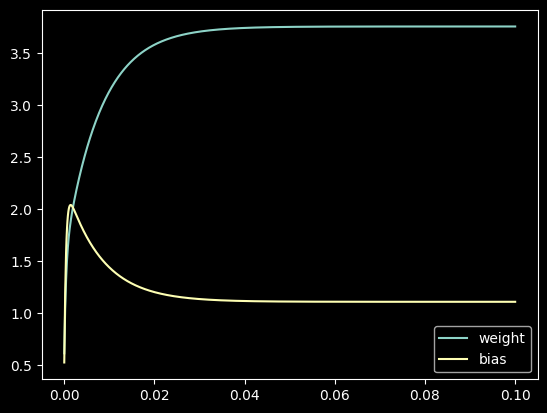

In [14]:
learning_rate = 0.0001
t = jnp.linspace(0, max_iter * learning_rate, max_iter)
plt.plot(t, w_t(t), label = 'weight')
plt.plot(t, b_t(t), label='bias')
plt.legend();
w_t(t)

In [15]:
@partial(jax.jit)
def gradients(weight, bias, x, y):
    return jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)


In [16]:
# Optimization problem
repetitions = 100
learning_rate = 0.001
batch_size = 64
max_iter = 100
weight = weight_0.copy()
bias = bias_0.copy()
weights = [[weight.copy()] for _ in range(repetitions)]
biases = [[bias.copy()] for _ in range(repetitions)]
for k in range(repetitions):
    for i in range(max_iter):
        key, sample_key = jr.split(key)
        ix = jr.choice(sample_key, jnp.arange(0, x.shape[0]), (batch_size,))
        # print(ix)
        dweight, dbias = gradients(weight, bias, x[ix], y[ix])
        weight += - learning_rate * dweight
        bias += - learning_rate * dbias
        weights[k].append(weight)
        biases[k].append(bias)
# weights = jnp.array(weights)
# biases = jnp.array(biases)
# print(f'Weight: {weight:.3f}, bias: {bias:.3f}')
# print(f'Loss: {loss(weight, bias, x, y)}')


In [59]:
@jax.jit
@partial(jax.vmap, in_axes=(0, 0, 0, 0, None))
def update(weight, bias, x_batch, y_batch, learning_rate):
    value, (dweight, dbias) = jax.value_and_grad(loss, argnums=(0, 1))(
        weight, bias, x_batch, y_batch)
    weight += - learning_rate * dweight
    bias += - learning_rate * dbias
    return value, weight, bias


# def loop_body(carry, weight, bias):
# Optimization problem
def sgd_run(key, learning_rate, batch_size, max_iter):
    repetitions = 1000
    
    weight = jnp.repeat(weight_0[None, None], repetitions, axis=0)
    bias = jnp.repeat(bias_0[None, None], repetitions, axis=0)
    weights = [weight]
    biases = [bias]
    values = []
    for i in range(max_iter):
        key, sample_key = jr.split(key)
        ix = jr.choice(sample_key, jnp.arange(
            0, x.shape[0]), (repetitions, batch_size))
        value, weight, bias = update(weight, bias, x[ix], y[ix], learning_rate)
        weights.append(weight)
        biases.append(bias)
        values.append(value)
    return jnp.array(values), jnp.array(weights).squeeze(), jnp.array(biases).squeeze()

max_iter = 1000
learning_rate = 0.1
batch_size = 1
values, weights, biases = sgd_run(key, learning_rate, batch_size, max_iter)

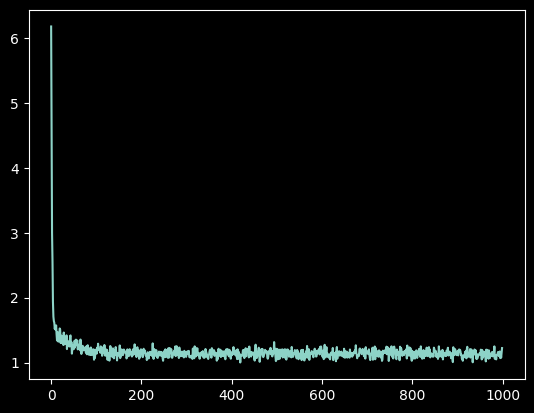

In [60]:
plt.plot(values.mean(1))

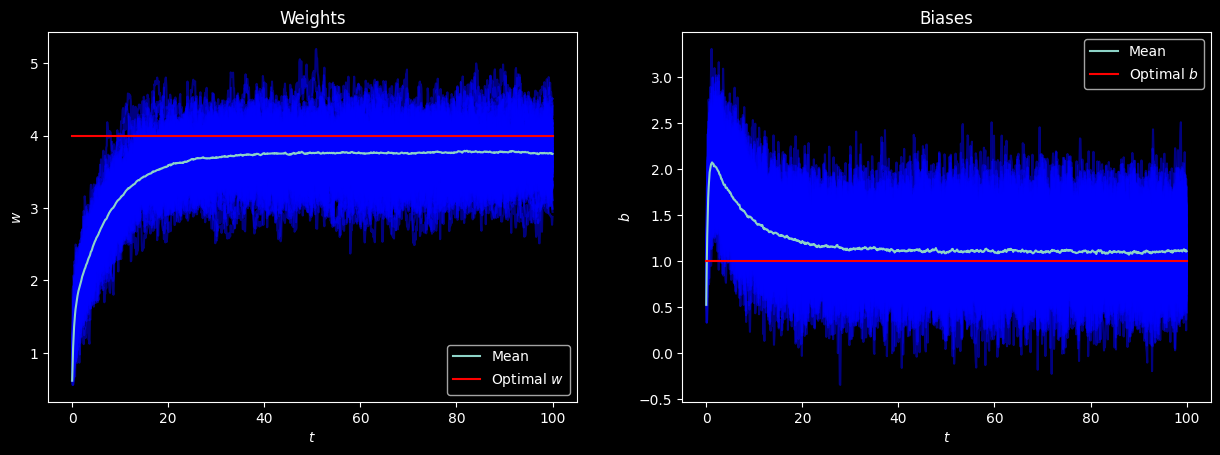

In [42]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(15)
t = jnp.linspace(0, max_iter * learning_rate,
                 max_iter+1)
for i in range(0, repetitions):
    axes[0].plot(t, weights[:, i], 'b', alpha=0.5)
    axes[1].plot(t, biases[:, i], 'b', alpha=0.5)
axes[0].plot(jnp.linspace(0, max_iter * learning_rate, max_iter+1),
             weights[:, :].mean(1), label='Mean')
axes[1].plot(jnp.linspace(0, max_iter * learning_rate, max_iter+1),
             biases[:, :].mean(1), label='Mean')
axes[0].plot(t, jnp.ones_like(t) * 4.0, 'r', label='Optimal $w$')
axes[1].plot(t, jnp.ones_like(t) * 1.0, 'r', label='Optimal $b$')
axes[0].set_title('Weights')
axes[1].set_title('Biases')
axes[0].set_ylabel('$w$')
axes[1].set_ylabel('$b$')
for axis in axes:
    axis.set_xlabel('$t$')
axes[0].legend();
axes[1].legend();
# Plot distribution of weight over time


In [ ]:
max_iter = 1000
learning_rate = 0.001
batch_sizes = 1
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(15)

weights, biases = sgd_run(key, learning_rate, batch_size, max_iter)
axes[i].hist(weights[-1, :] - weights[-1, :].mean(), 30,
                label=f'batch size: {batch_size}')
axes[i].set_xlabel('$w$')
axes[i].legend()
plt.title('Final $w$')
# sns.kdeplot(weights[-1,:]);


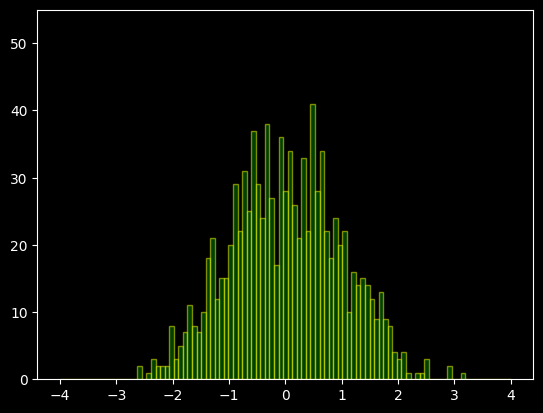

In [62]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)
# Fixing bin edges
HIST_BINS = np.linspace(-4, 4, 100)

# histogram our data with numpy
data = np.random.randn(1000)
n, _ = np.histogram(data, HIST_BINS)


def prepare_animation(bar_container):

    def animate(frame_number):
        # simulate new data coming in
        data = np.random.randn(1000)
        n, _ = np.histogram(data, HIST_BINS)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        return bar_container.patches
    return animate


fig, ax = plt.subplots()
_, _, bar_container = ax.hist(data, HIST_BINS, lw=1,
                              ec="yellow", fc="green", alpha=0.5)
ax.set_ylim(top=55)  # set safe limit to ensure that all data is visible.

ani = animation.FuncAnimation(fig, prepare_animation(bar_container), 50,
                              repeat=False, blit=True)
plt.show()


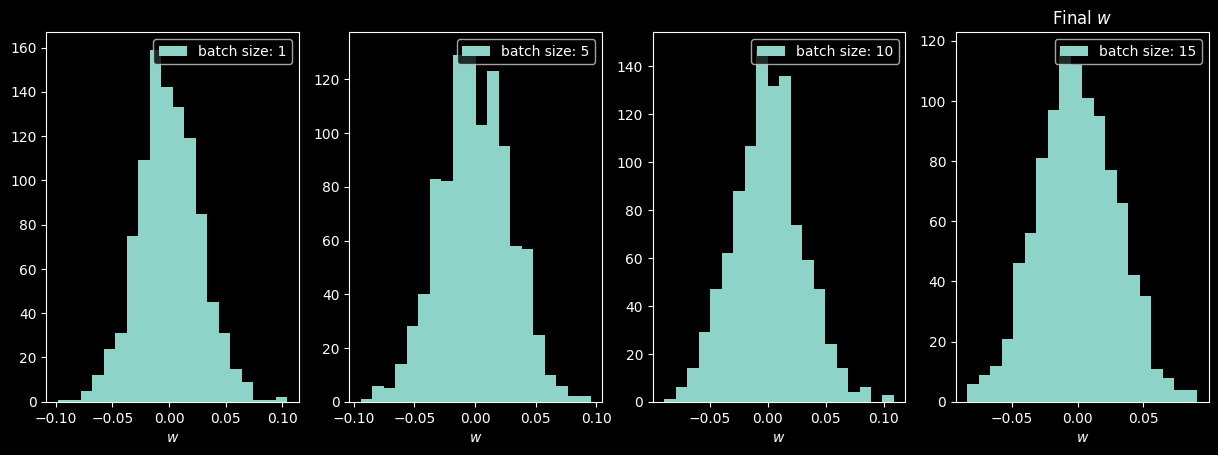

In [43]:
max_iter = 1000
learning_rate = 0.001
batch_sizes = [1, 5, 10, 15]
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(15)

for i, batch_size in enumerate(batch_sizes):
    weights, biases = sgd_run(key, learning_rate, batch_size, max_iter)
    axes[i].hist(weights[-1, :] - weights[-1, :].mean(), 30,
                 label=f'batch size: {batch_size}')
    axes[i].set_xlabel('$w$')
    axes[i].legend()
plt.title('Final $w$');
# sns.kdeplot(weights[-1,:]);


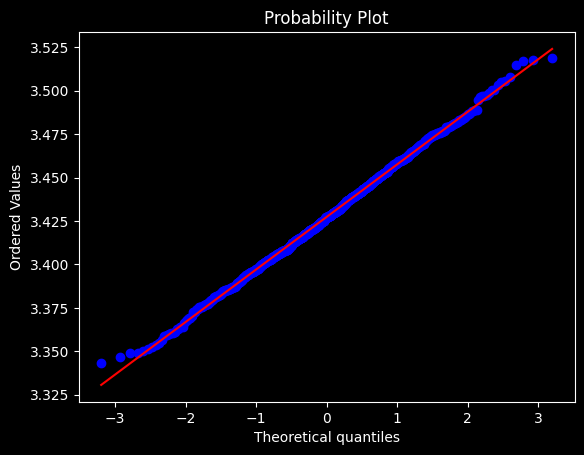

In [50]:
import numpy as np
import scipy.stats as stats

measurements = weights[-1,:]
stats.probplot(measurements, dist="norm", plot=plt);
